In [7]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

def Euclidean(x,y):
    return np.sqrt((y[0]-x[0])**2 + (y[1] - x[1])**2)

In [ ]:
# For webcam input:
from ast import ListComp

datadirectory = 'data'
PoseData = list()
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(os.path.join('..', datadirectory, 'MariaDancingSequence.webm'))
i = 0
imageName = "MariaMovementSequence_xyz_28Sept"
# MaxRecordings = 10
pose = mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)  # as pose:

while cap.isOpened():
  
  i += 1
  
  success, image = cap.read()
  if not success:
    print("Ignoring empty camera frame.")
    # If loading a video, use 'break' instead of 'continue'.
    break

  # Draw the pose annotation on the image.
  image.flags.writeable = True
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  results = pose.process(image)
  mp_drawing.draw_landmarks(
      image,
      results.pose_landmarks,
      mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
  
  newData = {coord + str(j):lm.__getattribute__(coord)  for j, lm in enumerate(results.pose_landmarks.landmark) for coord in ["x", "y", "z"]}
  PoseData.append(newData)

  # Flip the image horizontally for a selfie-view display.
  cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
  if (cv2.waitKey(5) & 0xFF == 27): ## or i>MaxRecording s :
    break
cap.release()
df = pd.DataFrame(PoseData)
df.to_csv(os.path.join("..","data", "csv", imageName + ".csv"))
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [8]:
import cv2
images = []
cap = cv2.VideoCapture(os.path.join('..', 'data', 'MariaDancingSequence.webm'))
# for i in range(315):
fromFrame = 0
tillFrame = 815
lastSuccessfulFrame = 0
numberOfsuccessivUnsuccessesToBreak = 20
unsuccesses = 0
frame = 0
while unsuccesses < numberOfsuccessivUnsuccessesToBreak:
  success, image = cap.read()
  if success and (frame>=fromFrame and frame<=tillFrame):
    images.append(image)
  else:
    images.append('empty')

  if not success:
    unsuccesses += 1
  else:
    unsuccesses = 0
    lastSuccessfulFrame = frame

  frame += 1

cap.release()

durationOfClip = (2 * 60 + 42)
fps = int((lastSuccessfulFrame) / durationOfClip)

In [3]:
fps = 15

Load the data from the cvs storage

In [9]:
fileName = "MariaMovementSequence_xyz_27Sept"
df = pd.read_csv(
    os.path.join("..","data", "csv", fileName + ".csv"), 
    header=0,
    index_col=0)
df["time"] = 1000 * df.index / fps

In [10]:
landmarks = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]
index_from_landmark = {name: i for i,name in enumerate(landmarks)}

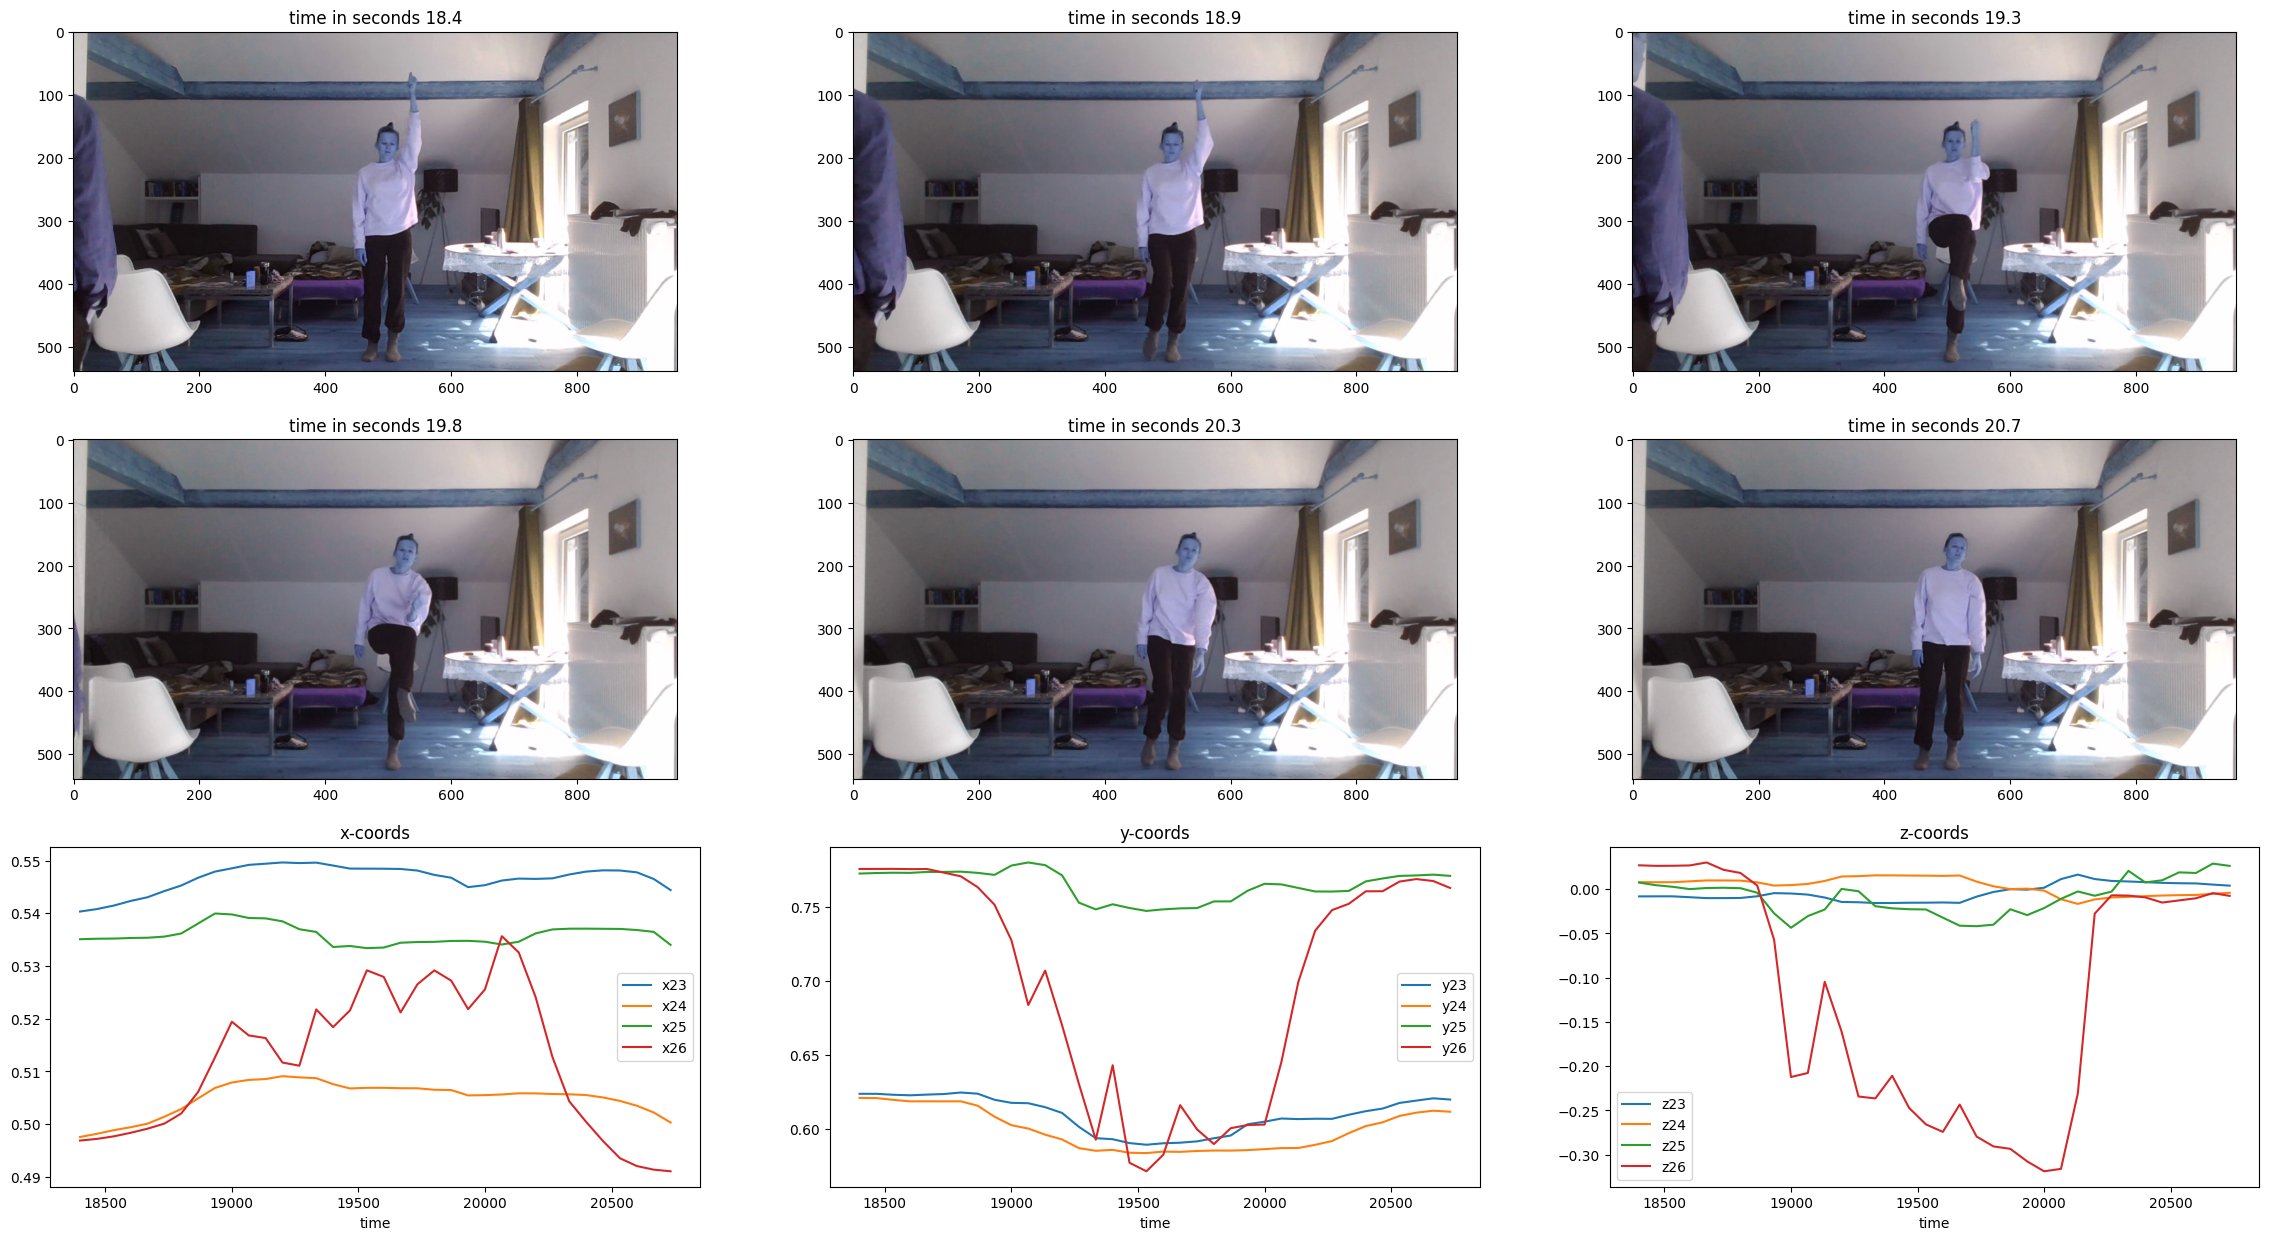

In [8]:
import matplotlib.pyplot as plt
startAt = 276
steps = 7
ncols = 3
fig, axes = plt.subplots(nrows=3, ncols=ncols)
# frame = startAt
for i in range(6):
    row = round(np.floor(i/ncols))
    col = i % ncols
    timeframe = (startAt + (i * steps))
    time = round(timeframe / fps, 1)
    axes[row,col].imshow(images[timeframe])
    axes[row,col].set_title('time in seconds {}'.format(time))
these = [index_from_landmark[i] for i in ['left_hip', 'right_hip', 'left_knee', 'right_knee']]
# print( [landmarks[i] for i in these])
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['x' + str(i) for i in these], ax=axes[2,0])
axes[2,0].set_title('x-coords')
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['y' + str(i) for i in these], ax=axes[2,1])
axes[2,1].set_title('y-coords')
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['z' + str(i) for i in these], ax=axes[2,2])
axes[2,2].set_title('z-coords')
fig.set_size_inches(28.5, 15.0)
# fig.set_size_inches(18.5, 8.0)
plt.show()

## Analysis

In [11]:
Annotations = {
    "hip_joint_right": [
        {"from": "00:05:12", "till": "00:07:11"},
        {"from": "00:44:03", "till": "00:46:03"}],
    "elbow_hinge_left": [
        {"from": "00:07:14", "till":"00:11:07"},
        {"from": "00:46:03", "till":"00:48:06"}],
    "pivot_right":[{"from": "00:48:07", "till": "00:49:13"}],
    "pivot_left":[{"from": "00:50:04", "till": "00:52:03"}],
    "rotation_shoulder_left": [{"from": "00:11:08" , "till":"00:14:02"}],
    "thumb_movement_left": [{"from": "00:14:03", "till": "00:18:10"}],
    "knee_hinge_right":[{"from":"00:18:11", "till": "00:21:01"}]
}

In [12]:
def lightenUp(x, byFactor=2):
    return np.add(x, np.divide((255 - x), byFactor)).astype(int)

def kdenLiveTimeToFrame(time, fps=15):
    secs = time.split(":")
    return int(secs[0]) * 60 + int(secs[1]) * fps + int(secs[2])
    

In [52]:
[(kdenLiveTimeToFrame(timeSpec["from"]), kdenLiveTimeToFrame(timeSpec["till"])) for gesture, times in Annotations.items() for timeSpec in times]

[(87, 116),
 (663, 693),
 (119, 172),
 (693, 726),
 (754, 783),
 (173, 212),
 (213, 280),
 (281, 316)]

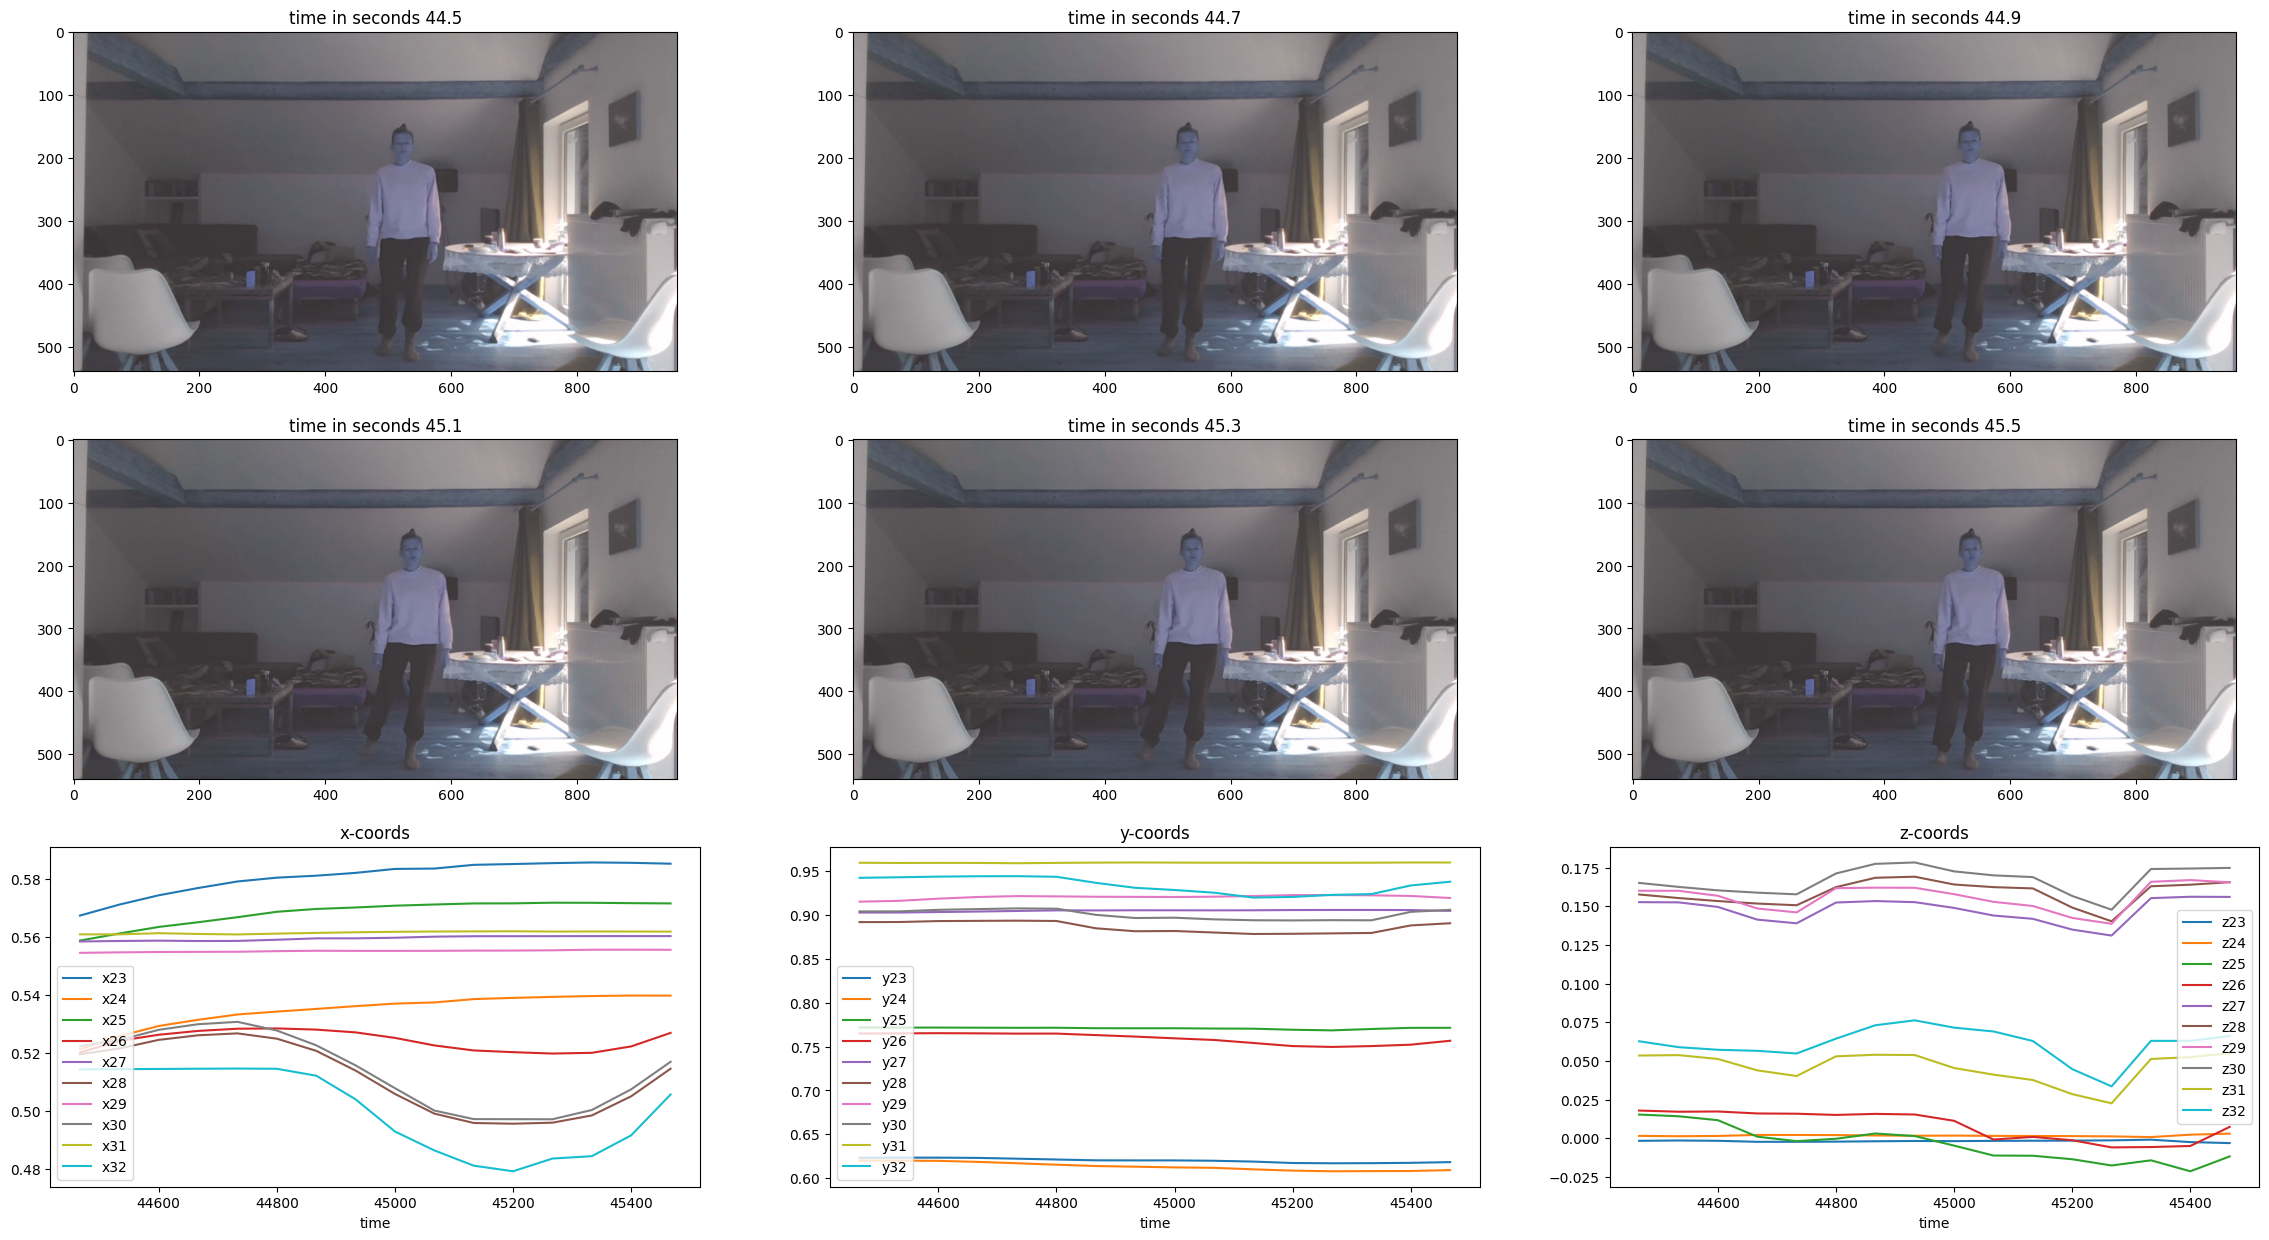

In [44]:
startAt = int(Annotations["leg_turn"]["from"] * fps / 1000)
steps = 3
ncols = 3
fig, axes = plt.subplots(nrows=3, ncols=ncols)
# frame = startAt
for i in range(6):
    row = round(np.floor(i/ncols))
    col = i % ncols
    timeframe = (startAt + (i * steps))
    time = round(timeframe / fps, 1)
    # print(timeframe)
    axes[row,col].imshow(lightenUp(images[timeframe], 5))
    axes[row,col].set_title('time in seconds {}'.format(time))
these = [index_from_landmark[i] for i in ['left_hip', 'right_hip', 'left_knee', 'right_knee',
'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index']]
# print( [landmarks[i] for i in these])
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['x' + str(i) for i in these], ax=axes[2,0])
axes[2,0].set_title('x-coords')
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['y' + str(i) for i in these], ax=axes[2,1])
axes[2,1].set_title('y-coords')
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['z' + str(i) for i in these], ax=axes[2,2])
axes[2,2].set_title('z-coords')
fig.set_size_inches(28.5, 15.0)
# fig.set_size_inches(18.5, 8.0)
plt.show()

## Gaussian Mixture Models

In [14]:
import numpy as np
from sklearn.mixture import GaussianMixture
import time

### Generate training data

In [15]:
def rescaleEntry(name, x, zero, scale):
    if name.startswith('x'):
        return (x - zero[0]) / scale
    elif name.startswith('y'):
        return (x - zero[1]) / scale
    elif name.startswith('z'):
        return (x - zero[2]) / scale
    else:
        return 0

In [16]:
def rescale(x):
    ## nose is 0
    nose = np.array([coord for name, coord in x.items() if name[1:] == str(index_from_landmark['nose'])])
    leftEye = np.array([coord for name, coord in x.items() if name[1:] == str(index_from_landmark['left_eye_outer'])])
    rightEye = np.array([coord for name, coord in x.items() if name[1:] == str(index_from_landmark['right_eye_outer'])])
    scale = np.linalg.norm(leftEye - rightEye)
    return {name + "_rescaled" : rescaleEntry(name, coord, nose, scale) for name, coord in x.items()}


In [17]:
df_rescaled_list = list()
for i, row in df.iterrows():
    df_rescaled_list.append(rescale(row))
df_rescaled = pd.DataFrame(df_rescaled_list).drop(["x0_rescaled", "y0_rescaled", "z0_rescaled"], axis=1)

In [70]:
X = 
GMM = GaussianMixture(n_components=3, random_state=0).fit(X)

In [ ]:
def generateDataFromAnnotation(df, anno):

    for name, speclist in anno.items():
        for specs in speclist:
            fromTimeFrame = kdenLiveTimeToFrame(specs["from"])
            tillTime
            df.iloc[]


In [13]:
fr = kdenLiveTimeToFrame(Annotations["rotation_shoulder_left"][0]["from"])
to = kdenLiveTimeToFrame(Annotations["rotation_shoulder_left"][0]["till"])

In [19]:
list(range(3,4))

[3]

In [18]:
batch_size = 4
till = to - batch_size
if till<= fr:
    
for i in range(fr,)
df.iloc[fr: to]

x0        y0        z0        x1        y1        z1        x2  \
173  0.517592  0.339078 -0.282070  0.522194  0.327523 -0.267667  0.524234   
174  0.517736  0.339049 -0.286365  0.522202  0.327479 -0.272124  0.524235   
175  0.517991  0.338957 -0.284242  0.522238  0.327356 -0.270233  0.524239   
176  0.518770  0.339007 -0.274914  0.522383  0.327347 -0.260613  0.524317   
177  0.519315  0.338996 -0.269077  0.522468  0.327306 -0.254568  0.524356   
178  0.520027  0.338990 -0.263673  0.522621  0.327297 -0.249086  0.524512   
179  0.520684  0.339032 -0.255915  0.522876  0.327336 -0.241306  0.524908   
180  0.521038  0.339093 -0.252530  0.523040  0.327381 -0.237932  0.525156   
181  0.521670  0.339594 -0.246998  0.523742  0.327691 -0.232134  0.525868   
182  0.522676  0.340233 -0.234308  0.524619  0.328026 -0.219228  0.526455   
183  0.525591  0.340228 -0.215306  0.526448  0.328028 -0.199919  0.527930   
184  0.526873  0.340379 -0.225657  0.527308  0.328133 -0.210982  0.528608   
185  0.528088  0.340481 -0.218479  0.527712  0.328153 -0.204477  0.528739   
186  0.527867  0.340678 -0.211805  0.527573  0.328188 -0.196859  0.528654   
187  0.528059  0.339844 -0.195807  0.527466  0.327504 -0.180970  0.528541   
188  0.528080  0.337501 -0.193099  0.527365  0.325412 -0.178784  0.528107   
189  0.527874  0.336476 -0.192330  0.526921  0.324381 -0.178112  0.527390   
190  0.527741  0.335905 -0.179970  0.526477  0.323752 -0.165680  0.526746   
191  0.527642  0.335319 -0.177657  0.525994  0.322976 -0.163363  0.526118   
192  0.527578  0.335277 -0.183406  0.525408  0.322681 -0.169921  0.525381   
193  0.527519  0.335327 -0.164100  0.524969  0.322750 -0.151910  0.524748   
194  0.527608  0.335384 -0.151986  0.524873  0.322791 -0.140278  0.524590   
195  0.527728  0.334453 -0.131921  0.524796  0.321969 -0.120629  0.524449   
196  0.527557  0.333003 -0.083399  0.524089  0.320690 -0.066599  0.523733   
197  0.527185  0.331820 -0.084174  0.523488  0.319830 -0.067208  0.523147   
198  0.526295  0.331998 -0.096757  0.522725  0.319849 -0.080295  0.522517   
199  0.525948  0.332062 -0.109190  0.522473  0.319764 -0.092568  0.522319   
200  0.525939  0.332211 -0.121459  0.522506  0.319801 -0.105369  0.522380   
201  0.525860  0.332332 -0.125980  0.522509  0.319862 -0.109118  0.522420   
202  0.525816  0.333753 -0.142116  0.522519  0.321485 -0.122403  0.522454   
203  0.525782  0.335548 -0.150504  0.522574  0.323264 -0.130707  0.522590   
204  0.525754  0.335831 -0.172252  0.522613  0.323778 -0.152230  0.522674   
205  0.525637  0.336264 -0.179673  0.522631  0.324455 -0.160890  0.522695   
206  0.525570  0.336240 -0.179173  0.522645  0.324434 -0.161018  0.522711   
207  0.522388  0.336303 -0.196367  0.521427  0.324347 -0.177116  0.522188   
208  0.522215  0.336246 -0.216662  0.521433  0.324152 -0.197070  0.522205   
209  0.519639  0.339319 -0.298463  0.520091  0.325553 -0.280554  0.521519   
210  0.518096  0.340896 -0.362869  0.518774  0.326543 -0.344646  0.520619   
211  0.517312  0.341186 -0.313474  0.518337  0.326593 -0.295066  0.520302   

           y2        z2        x3  ...       x30       y30       z30  \
173  0.327934 -0.267662  0.526148  ...  0.501005  0.927543  0.141105   
174  0.327902 -0.272120  0.526154  ...  0.500957  0.927463  0.142188   
175  0.327816 -0.270233  0.526206  ...  0.500911  0.927475  0.138329   
176  0.327805 -0.260617  0.526376  ...  0.500861  0.927357  0.131208   
177  0.327756 -0.254576  0.526468  ...  0.500854  0.926909  0.126395   
178  0.327748 -0.249094  0.526688  ...  0.500853  0.926547  0.118876   
179  0.327792 -0.241314  0.527074  ...  0.500659  0.925611  0.114770   
180  0.327834 -0.237939  0.527256  ...  0.500653  0.925044  0.106781   
181  0.328151 -0.232139  0.527665  ...  0.500612  0.925194  0.096704   
182  0.328445 -0.219238  0.527980  ...  0.500444  0.926310  0.092653   
183  0.328442 -0.199935  0.529196  ...  0.499991  0.926311  0.096504   
184  0.328494 -0.210997  0.529711  ...  0.499897  0.925873  0.1017